<a href="https://colab.research.google.com/github/haorant14/596_final/blob/main/csci596_neworkVis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
import timm
from einops import rearrange
import torch.nn.functional as F
from typing import List, Tuple
import requests
from io import BytesIO

In [26]:
# Install required packages
!pip install pycocotools
!pip install requests tqdm

import os
import json
import requests
from tqdm import tqdm
from pycocotools.coco import COCO

# Create directory for COCO data
!mkdir -p /content/coco
!mkdir -p /content/coco/images
!mkdir -p /content/coco/annotations

# Download COCO annotations
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d /content/coco

# Initialize COCO API for instance annotations
coco = COCO('/content/coco/annotations/instances_train2017.json')

# Let's get images from a few specific categories
cat_ids = coco.getCatIds(catNms=['person', 'dog', 'cat', 'car'])
img_ids = []
for cat_id in cat_ids:
    imgs = coco.getImgIds(catIds=[cat_id])[:5]  # Get 5 images per category
    img_ids.extend(imgs)
img_ids = list(set(img_ids))  # Remove duplicates

# Download selected images
for img_id in tqdm(img_ids):
    img_info = coco.loadImgs(img_id)[0]
    img_url = f"http://images.cocodataset.org/train2017/{img_info['file_name']}"

    # Download image
    img_path = os.path.join('/content/coco/images', img_info['file_name'])
    if not os.path.exists(img_path):
        response = requests.get(img_url)
        if response.status_code == 200:
            with open(img_path, 'wb') as f:
                f.write(response.content)

# Print summary
print(f"Downloaded {len(img_ids)} images from categories: person, dog, cat, car")
print("Images are stored in /content/coco/images/")

# List downloaded images
!ls /content/coco/images

replace /content/coco/annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/coco/annotations/instances_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/coco/annotations/captions_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/coco/annotations/captions_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/coco/annotations/person_keypoints_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/coco/annotations/person_keypoints_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
loading annotations into memory...
Done (t=34.02s)
creating index...
index created!


100%|██████████| 19/19 [00:00<00:00, 19789.37it/s]

Downloaded 19 images from categories: person, dog, cat, car
Images are stored in /content/coco/images/
000000032773.jpg  000000204800.jpg  000000262148.jpg  000000360449.jpg	000000491525.jpg
000000073729.jpg  000000229387.jpg  000000286720.jpg  000000360452.jpg	000000524291.jpg
000000098304.jpg  000000262145.jpg  000000294918.jpg  000000393223.jpg	000000532491.jpg
000000196610.jpg  000000262146.jpg  000000311301.jpg  000000417802.jpg


Using device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly in

Loading and preprocessing image...


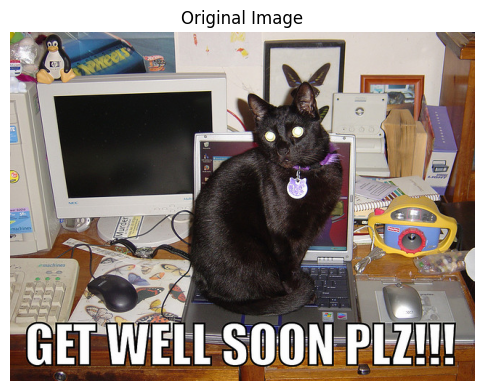


Analyzing ResNet features...

Visualizing layer1 features:


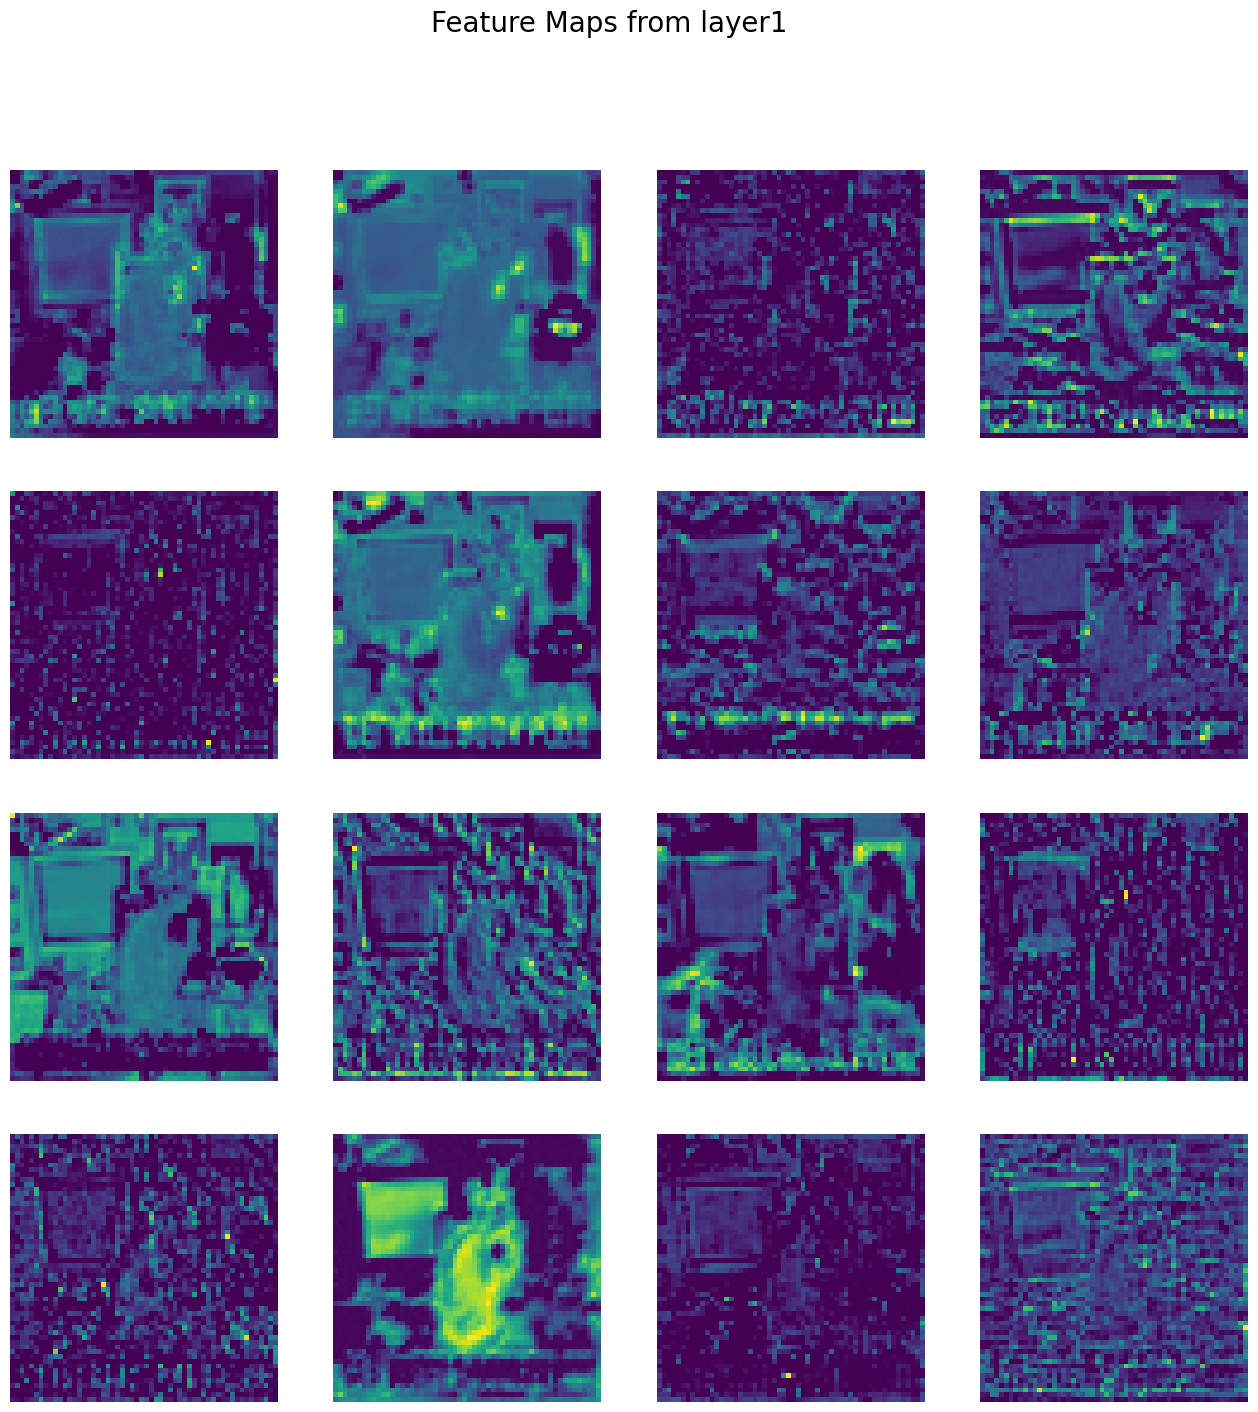


Visualizing layer2 features:


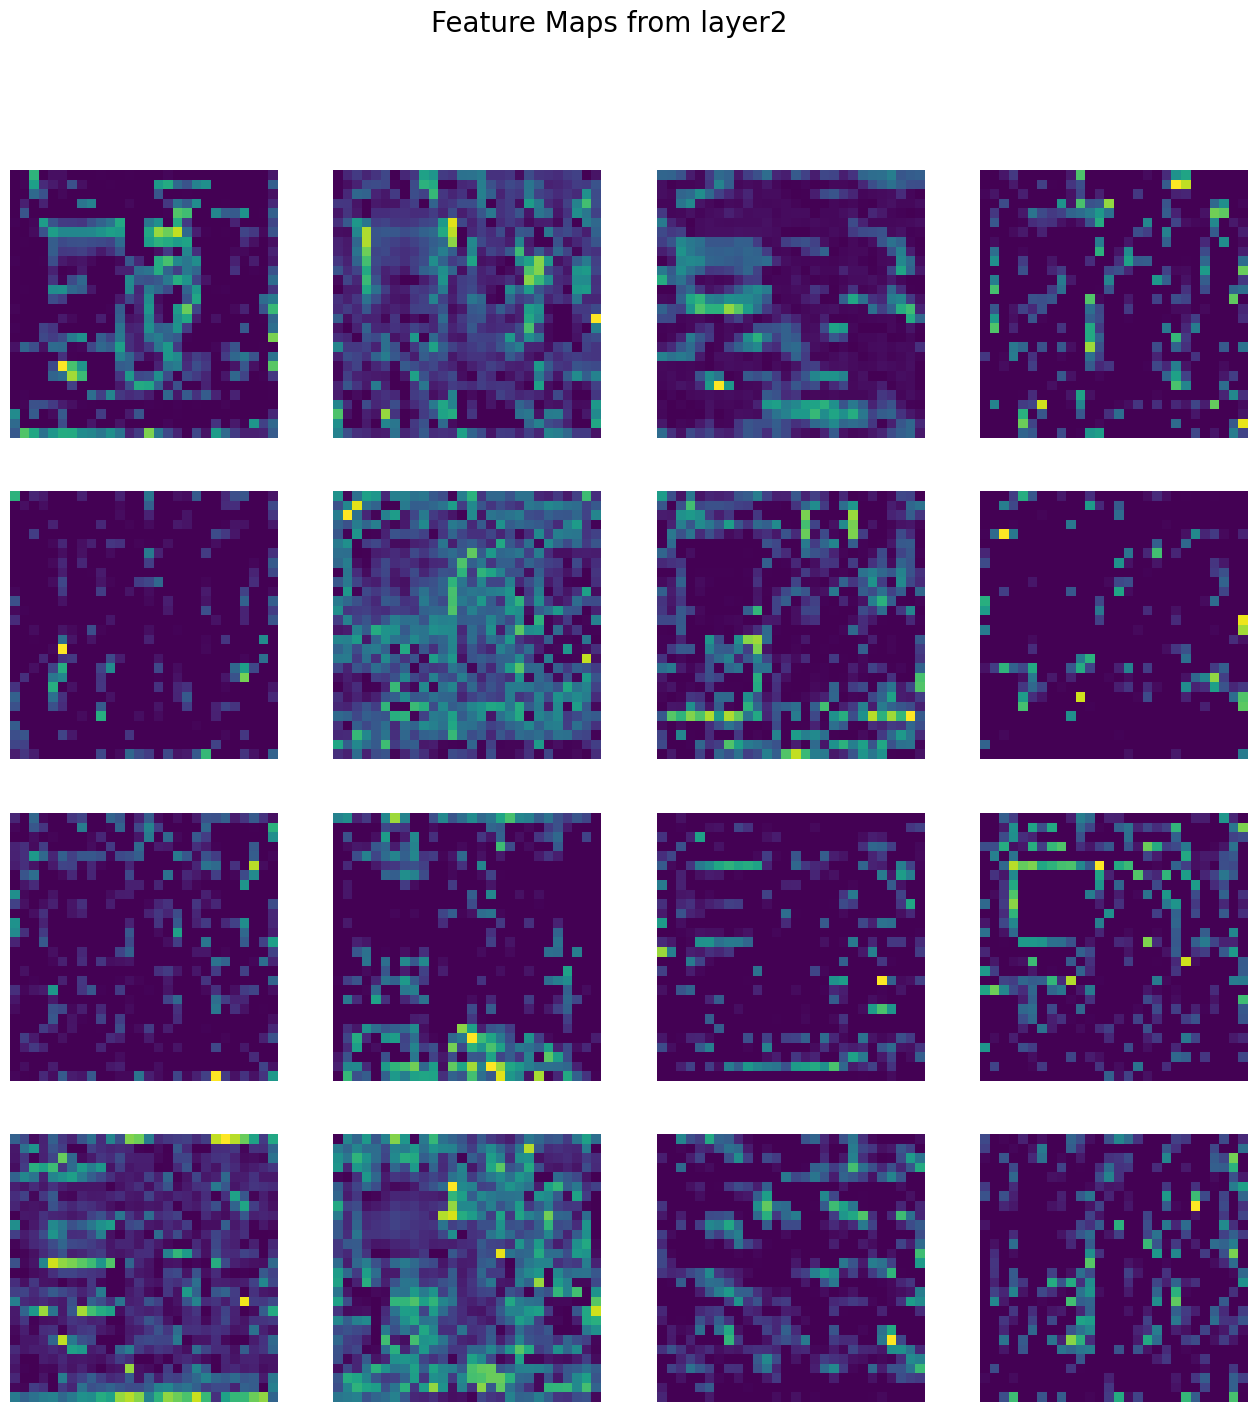


Visualizing layer3 features:


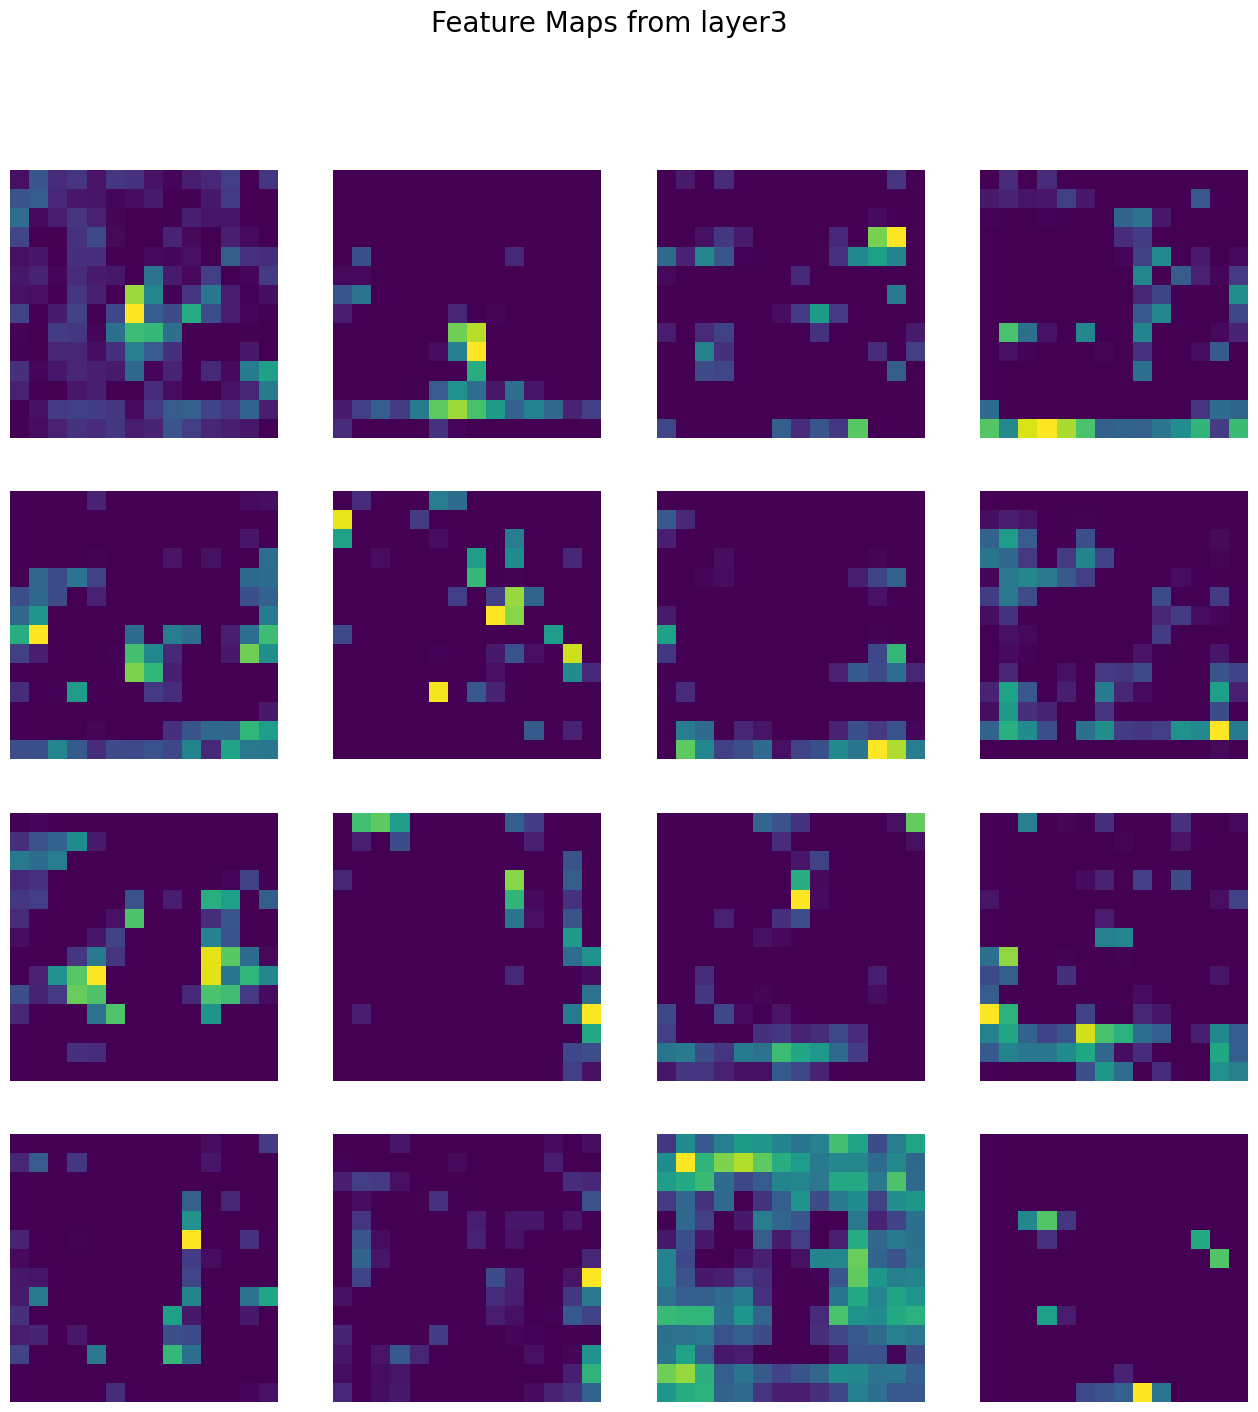


Visualizing layer4 features:


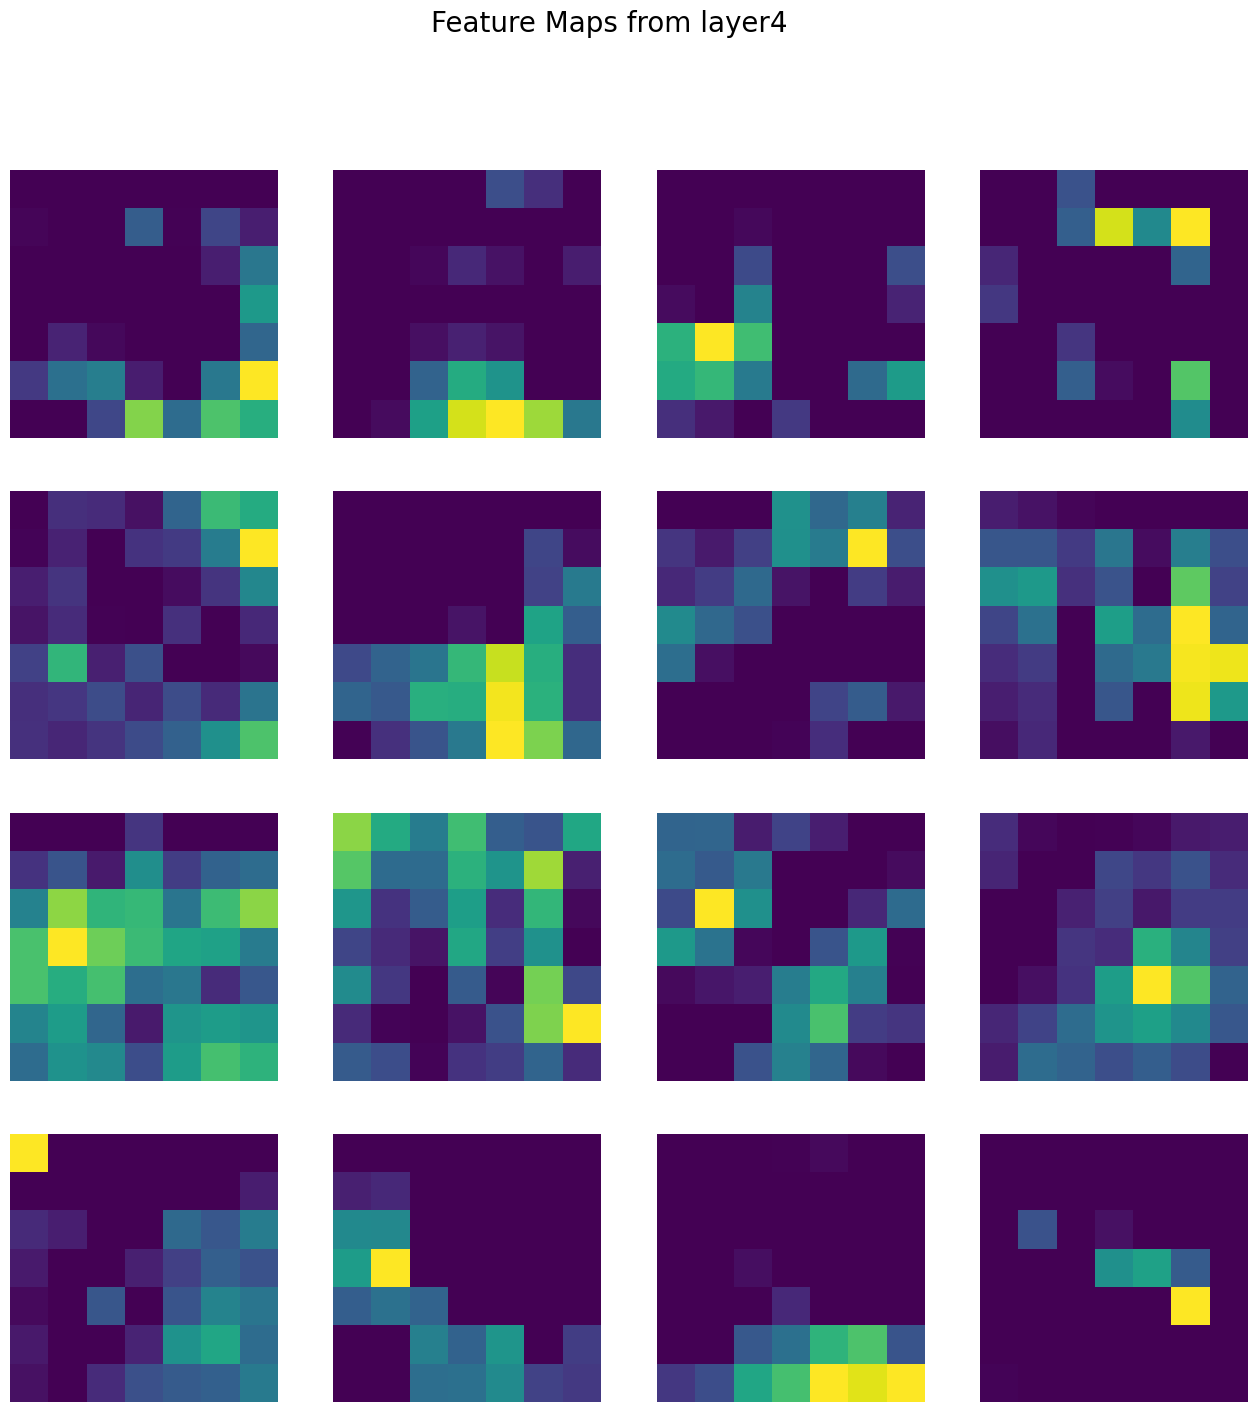

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ViT attention patterns from layer 0:


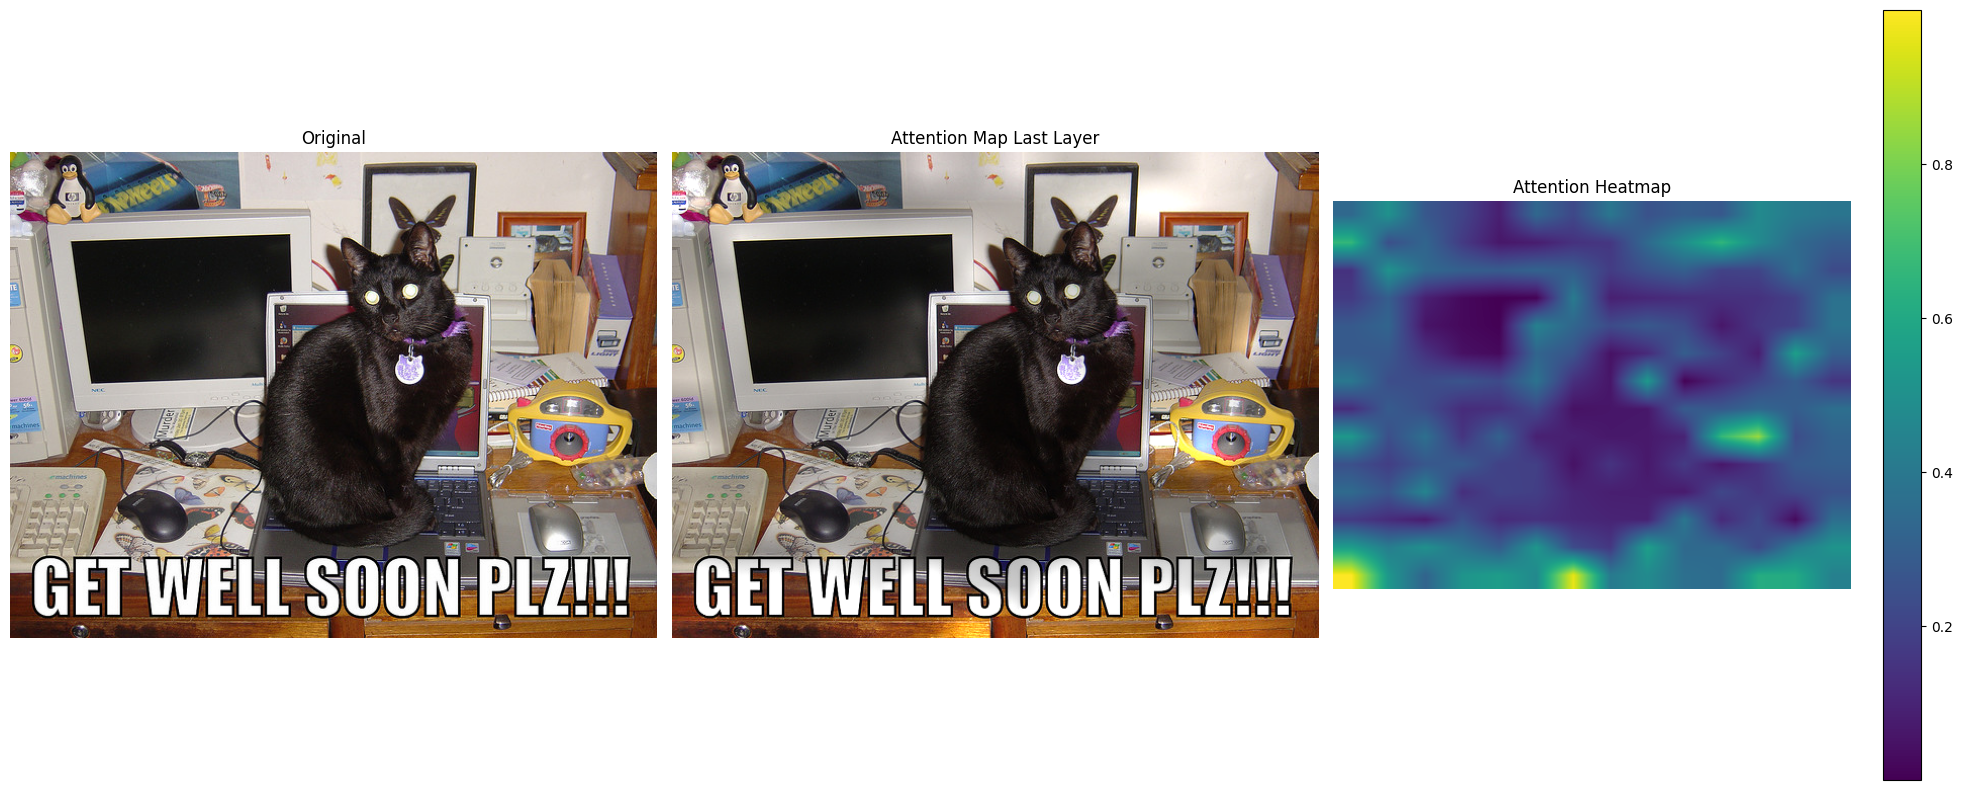


ViT attention patterns from layer 5:


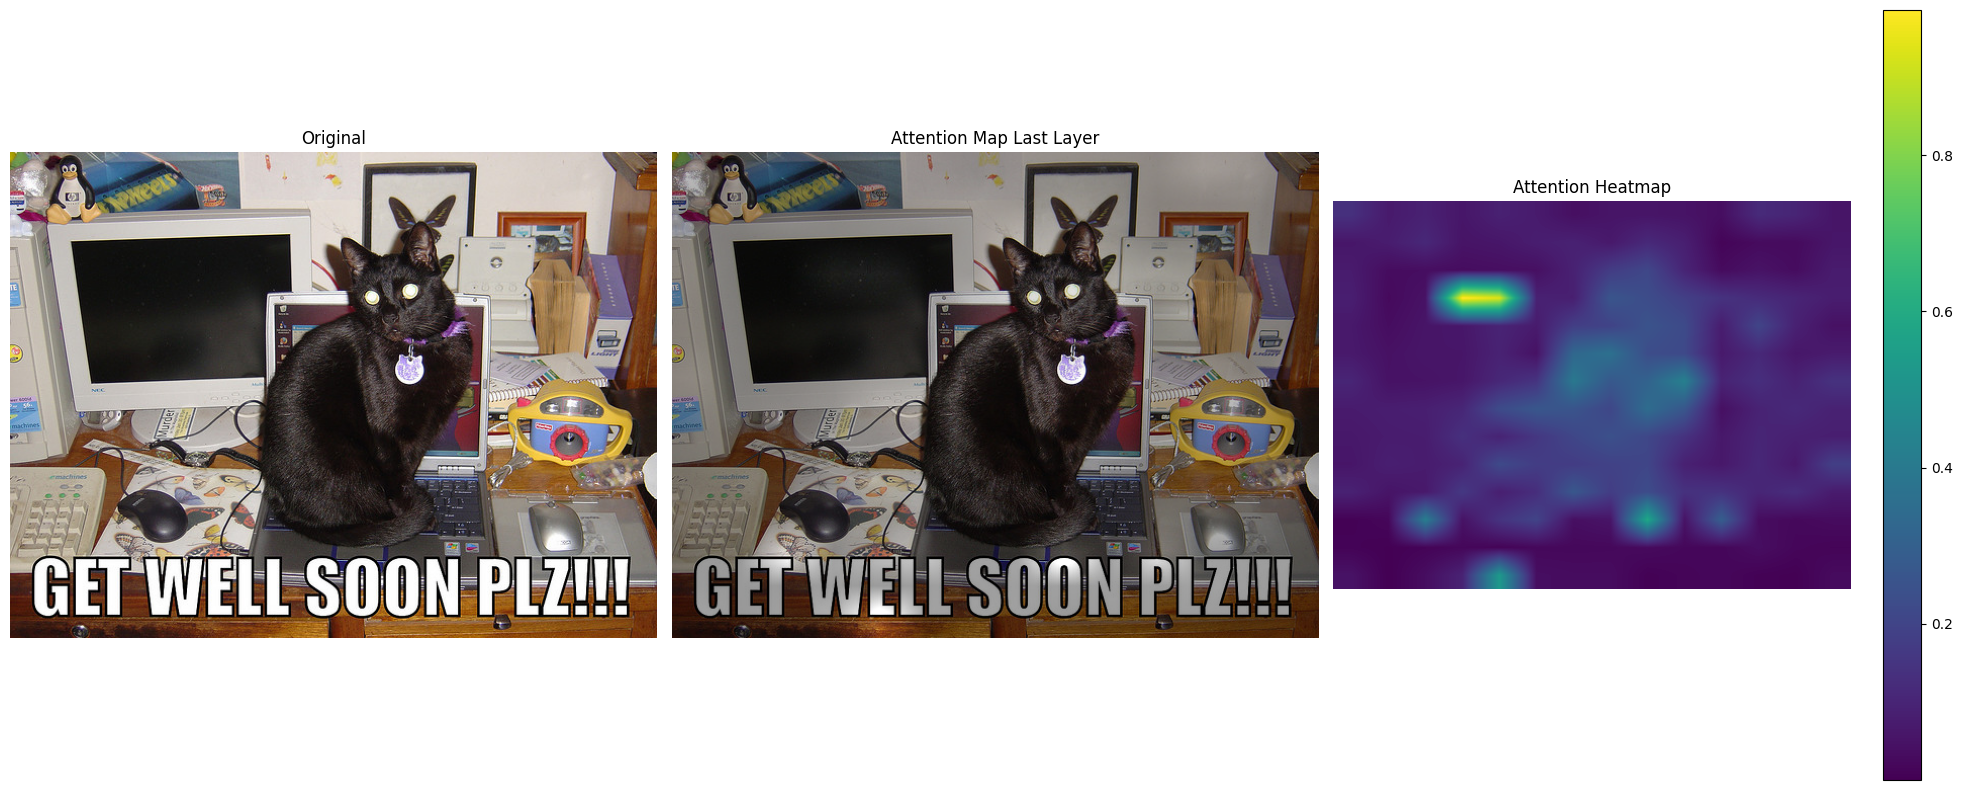


ViT attention patterns from layer 11:


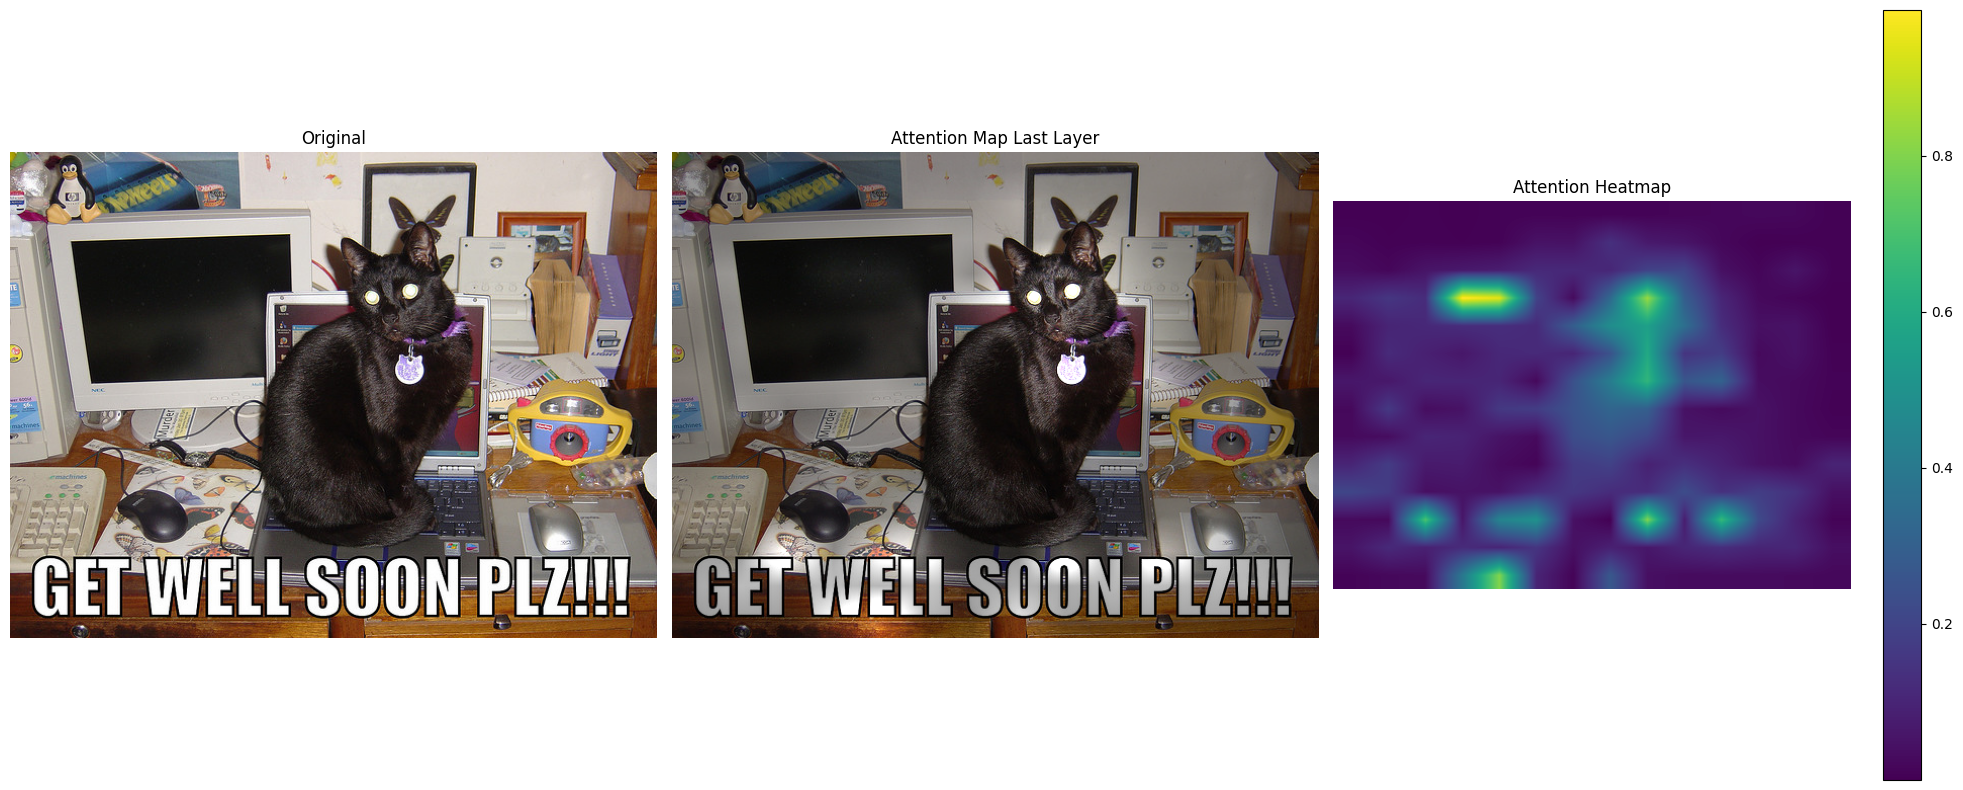

In [27]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
from typing import List

# Install transformers
!pip install transformers

from transformers import ViTModel, ViTFeatureExtractor

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained ResNet model
resnet = torchvision.models.resnet50(pretrained=True).to(device)
resnet.eval()

# Load pre-trained ViT model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224', output_attentions=True).to(device)
vit_model.eval()

# Image preprocessing for ResNet
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    img_array = np.array(image)
    input_tensor = transform_resnet(image)
    return input_tensor.unsqueeze(0).to(device), img_array

# ResNet Feature Extractor
class FeatureExtractor():
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id):
        def fn(_, __, output):
            self.features[layer_id] = output
        return fn

    def __call__(self, x):
        _ = self.model(x)
        return self.features

def visualize_layer_features(features, layer_name):
    # Get the feature maps from the layer
    feature_maps = features[layer_name][0]
    # Normalize the feature maps
    feature_maps = feature_maps.detach().cpu()
    num_feature_maps = feature_maps.shape[0]
    size = feature_maps.shape[1]
    # Plot the first 16 feature maps
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=20)
    plt.show()

def visualize_vit_attention(image_path, vit_model, feature_extractor, layer_index=-1):
    """
    Visualizes attention patterns with both overlay and heatmap views.

    Args:
        image_path: Path to the input image
        vit_model: Pre-trained ViT model
        feature_extractor: ViT feature extractor
        layer_index: Which transformer layer to visualize (-1 for last layer)
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors='pt')
    inputs = {k:v.to(vit_model.device) for k,v in inputs.items()}

    # Get model outputs
    with torch.no_grad():
        outputs = vit_model(**inputs)
        attentions = outputs.attentions

    # Get attention from specified layer
    attn = attentions[layer_index]  # Shape: [batch_size, num_heads, seq_len, seq_len]

    # Average attention across all heads
    attn_map = attn.mean(dim=1)  # Shape: [batch_size, seq_len, seq_len]

    # Get attention from CLS token to patch tokens
    cls_attn = attn_map[0, 0, 1:]  # Remove CLS token attention to itself

    # Reshape attention map to square grid
    grid_size = int(np.sqrt(cls_attn.shape[0]))
    attention_map = cls_attn.reshape(grid_size, grid_size).cpu().numpy()

    # Normalize attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)

    # Convert PIL Image to numpy array
    original_image = np.array(image)

    # Resize attention map to match original image size
    attention_map_resized = cv2.resize(attention_map,
                                     (original_image.shape[1], original_image.shape[0]),
                                     interpolation=cv2.INTER_LINEAR)

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Plot original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Plot attention overlay
    # Create a copy of the original image with slightly reduced brightness
    overlay_image = original_image.copy().astype(float) * 0.6
    # Apply attention map as brightness adjustment
    for c in range(3):  # For each color channel
        overlay_image[:,:,c] = np.minimum(
            overlay_image[:,:,c] * (1 + 2 * attention_map_resized),
            255
        )
    axes[1].imshow(overlay_image.astype(np.uint8))
    axes[1].set_title('Attention Map Last Layer')
    axes[1].axis('off')

    # Plot raw attention heatmap
    im = axes[2].imshow(attention_map_resized, cmap='viridis')
    axes[2].set_title('Attention Heatmap')
    axes[2].axis('off')

    # Add colorbar
    plt.colorbar(im, ax=axes[2])

    plt.tight_layout()
    plt.show()

def analyze_models(image_path):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Loading and preprocessing image...")
    input_tensor, original_image = load_and_preprocess_image(image_path)

    # Display original image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # ResNet analysis
    print("\nAnalyzing ResNet features...")
    resnet_layers = ['layer1', 'layer2', 'layer3', 'layer4']
    resnet_extractor = FeatureExtractor(resnet, resnet_layers)
    resnet_features = resnet_extractor(input_tensor)

    for layer in resnet_layers:
      print(f"\nVisualizing {layer} features:")
      visualize_layer_features(resnet_features, layer)

    # Load ViT model and feature extractor
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224',
                                        output_attentions=True).to(device)
    vit_model.eval()

    # Visualize attention for different layers
    for layer_idx in [0, 5, 11]:  # early, middle, and last layer
        print(f"\nViT attention patterns from layer {layer_idx}:")
        visualize_vit_attention(image_path, vit_model, feature_extractor, layer_idx)


# 000000262148.jpg
# 000000286720.jpg
# 000000360449.jpg
# 000000360452.jpg
# 000000417802.jpg!!!!
# Example usage
image_path = '/content/coco/images/000000417802.jpg'
analyze_models(image_path)


Colab doesn't allow for interactive plots, but you can change the displayed plot by changing the variable values.

The program generates a heat map that overlays the original image with a selected feature map and a selected attention layer. You can set the opacity of an option to 0 if you don't want to see it.

In [ ]:
!pip install moderngl
import moderngl
import numpy as np
from PIL import Image
from google.colab import files
import threading
from array import array

In [692]:
def analyze_models(image_path, feature_layer, feature_index, feature_opacity, attention_layer, attention_opacity, inverse_opacity, threshold):

    try:
        # Load and preprocess image
        input_tensor, original_image = load_and_preprocess_image(image_path)

        # ResNet analysis
        resnet_layers = ['layer1', 'layer2', 'layer3', 'layer4']
        resnet_extractor = FeatureExtractor(resnet, resnet_layers)
        resnet_features = resnet_extractor(input_tensor)

        # ViT analysis
        inputs = feature_extractor(images=Image.open(image_path).convert('RGB'), return_tensors='pt')
        inputs = {k:v.to(device) for k,v in inputs.items()}

        with torch.no_grad():
            outputs = vit_model(**inputs)
            attentions = outputs.attentions

        # Open original image
        raw_image = Image.open(image_path)

        # Get the selected feature map
        feature_maps = resnet_features[feature_layer][0]
        feature_maps = feature_maps.detach().cpu()
        feature_map = feature_maps[feature_index].numpy()

        # Normalize the values in the feature map (0 - 255)
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-8) * 255
        if inverse_opacity:
          feature_map = 255 - feature_map
        # Check for thresholds
        if threshold >= 0:
          feature_map[feature_map >= threshold] = 255
          feature_map[feature_map < threshold] = 0
        # Set feature opacity
        feature_map = feature_map * feature_opacity
        feature_map_resized = cv2.resize(feature_map, raw_image.size, interpolation=cv2.INTER_LINEAR)
        # Create the overlay for the feature map
        feature_overlay = np.full((raw_image.size[1], raw_image.size[0], 4), [255, 0, 0, 0])
        feature_overlay[:, :, -1] = feature_map_resized
        feature_img = Image.fromarray(np.flipud(feature_overlay.astype(np.uint8)))

        # Get attention from specified layer
        attn = attentions[attention_layer]
        attn_map = attn.mean(dim=1)
        cls_attn = attn_map[0, 0, 1:]
        grid_size = int(np.sqrt(cls_attn.shape[0]))
        attention_map = cls_attn.reshape(grid_size, grid_size).cpu().numpy()

        # Normalize values in the attention layer (0 - 255)
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8) * 255
        if inverse_opacity:
          attention_map = 255 - attention_map
        # Check for threshold value
        if threshold >= 0:
          attention_map[attention_map >= threshold] = 255
          attention_map[attention_map < threshold] = 0
        # Set feature opacity
        attention_map = attention_map * attention_opacity
        attention_map_resized = cv2.resize(attention_map, raw_image.size, interpolation=cv2.INTER_LINEAR)
        # Create the overlay for the attention layer
        attention_overlay = np.full((raw_image.size[1], raw_image.size[0], 4), [0, 0, 255, 0])
        attention_overlay[:, :, -1] = attention_map_resized
        attention_img = Image.fromarray(np.flipud(attention_overlay.astype(np.uint8)))

        # Combine overlays
        combined_overlay = np.full((raw_image.size[1], raw_image.size[0], 4), [0, 0, 0, 0])
        for r in range(raw_image.size[1]):
          for c in range(raw_image.size[0]):
            if feature_overlay[r][c][3] > attention_overlay[r][c][3]:
              combined_overlay[r][c] = [255, 0, attention_overlay[r][c][3], feature_overlay[r][c][3]]
            else:
              combined_overlay[r][c] = [feature_overlay[r][c][3], 0, 255, attention_overlay[r][c][3]]
        img_overlay = Image.fromarray(np.flipud(combined_overlay.astype(np.uint8)))

        # Set up OpenGL context
        ctx = moderngl.create_context(standalone=True, backend='egl')
        # Shader programs
        prog = ctx.program(
            vertex_shader="""
                #version 330

                in vec2 in_vert;
                in vec2 in_texcoord;

                out vec2 uvs;

                void main() {
                    uvs = in_texcoord;
                    gl_Position = vec4(in_vert, 0.0, 1.0);
                }
            """,
            fragment_shader="""
                #version 330

                uniform sampler2D img_tex;
                uniform sampler2D feature_tex;
                uniform sampler2D attention_tex;

                in vec2 uvs;

                out vec4 f_color;

                void main() {
                    vec4 img_color = vec4(texture(img_tex, uvs).rgb, 1.0);
                    f_color = img_color;
                }
            """,
        )

        img = raw_image.convert('RGBA').transpose(Image.FLIP_TOP_BOTTOM)
        img.paste(img_overlay, (0, 0), mask = img_overlay)

        img_texture = ctx.texture(img.size, components=4, data=img.tobytes())
        feature_texture = ctx.texture(img.size, components=4, data=feature_img.tobytes())
        attention_texture = ctx.texture(img.size, components=4, data=attention_img.tobytes())

        prog['img_tex'] = 0

        img_texture.use(location=0)

        # Defining the quad
        vbo = ctx.buffer(
            np.array([
              -1.0, 1.0, 0.0, 1.0,  # Top left
              1.0, 1.0, 1.0, 1.0,   # Top right
              -1.0, -1.0, 0.0, 0.0, # Bottom left
              1.0, -1.0, 1.0, 0.0   # Bottom right
            ], dtype='f4')
        )

        vao = ctx.vertex_array(prog, [(vbo, '2f 2f', 'in_vert', 'in_texcoord')])

        fbo = ctx.framebuffer(
          color_attachments=[img_texture]
        )

        vao.render()
        return Image.frombytes("RGBA", fbo.size, fbo.color_attachments[0].read(), "raw", "RGBA", 0, -1)

    except Exception as e:
        print(f"Error during visualization: {str(e)}")

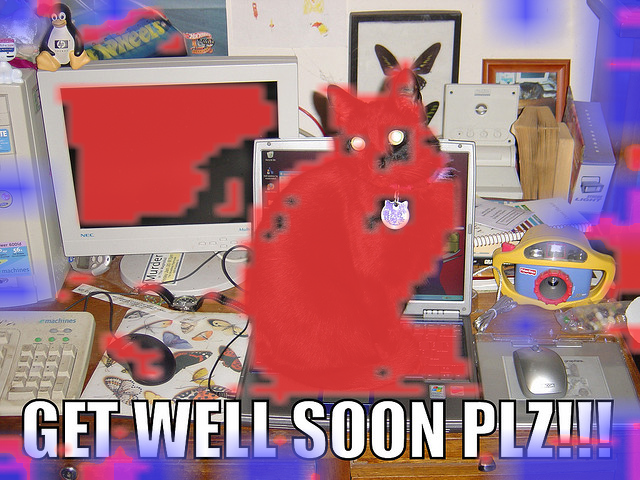

In [693]:
# Example usage
image_path = '/content/coco/images/000000417802.jpg'

# Feature map settings (red)
feature_layer = 'layer1'
feature_index = 13
feature_opacity = 0.75

# Attention layer settings (blue)
attention_layer = 1
attention_opacity = 0.75

# Highlights become transparent instead
inverse_opacity = False

# Highlights certain areas based on a certain threshold (0 - 255, -1 to turn off)
threshold = 128

analyze_models(image_path, feature_layer, feature_index, feature_opacity, attention_layer, attention_opacity, inverse_opacity, threshold)